In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os
%matplotlib inline

import pandas as pd
pd.set_option('display.max_columns', 500)

import numpy as np
np.bool = np.bool_

from matplotlib import pyplot as plt
import seaborn as sns


pd.set_option("display.precision", 2)
from IPython.display import Image

import xgboost as xgb
import tensorflow as tf

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel, VarianceThreshold


In [ ]:
# training data without labels
features = pd.read_csv('dengue_features_train.csv')
label = pd.read_csv('dengue_labels_train.csv')
test = pd.read_csv('dengue_features_test.csv')

#training data with labels
df=pd.merge(features, label, how='left', on =['city', 'year', 'weekofyear'])

In [ ]:
# split data by city
sj_features = features[features.city=='sj']
iq_features = features[features.city=='iq']
sj_labels = label[label.city=='sj']
iq_labels = label[label.city=='iq']

#load final test data
sj_test = test[test.city=='sj']
iq_test = test[test.city=='iq']

### Features and their descriptions

In [ ]:
# Step 1: fillna with most recent value , should use for different cities (2 seperate tables)
def fill_na(df):
    for feature in df.keys():
        df[feature].fillna(method='ffill', inplace=True)
    return df

# Step 2 : fix wrong values
def wrong_week_num(df):
    df.loc[df["weekofyear"] == 53, "weekofyear"] = 1
    return df

# Step 3 : month & season featurea
def season_feature(df):
    df['season']=0
    df['month'] = pd.DatetimeIndex(df['week_start_date']).month.astype(int)
    df.loc[(df['month'] >= 3) & (df['month'] <6), 'season'] = 1
    df.loc[(df['month'] >= 6) & (df['month'] <9), 'season'] = 2
    df.loc[(df['month'] >= 9) & (df['month'] <12), 'season'] = 3
    df.loc[(df['month'] == 12) & (df['month'] <=2), 'season'] = 4
    return df

# cyclincal time feature
def other_time_features(df):
    day = 60*60*24
    week = 7*day
    year = 365.2425*day
    df['week_start_date'] = pd.to_datetime(df['week_start_date'])#, format='%Y.%m.%d %H:%M:%S') # convert datetype
    df['Seconds'] = df['week_start_date'].map(pd.Timestamp.timestamp) # convert to Seconds
    df['week_sin'] = np.sin(df['Seconds'] * (2* np.pi / week))
    df['week_cos'] = np.cos(df['Seconds'] * (2 * np.pi / week))
    df['year_sin'] = np.sin(df['Seconds'] * (2 * np.pi / year))
    df['year_cos'] = np.cos(df['Seconds'] * (2 * np.pi / year))
    df=df.drop(['Seconds', 'week_start_date'], axis=1)
    return df

def avg_feature(df):
    df['avg_reanalysis'] = df[['reanalysis_air_temp_k','reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
                                    'reanalysis_max_air_temp_k','reanalysis_min_air_temp_k']].mean(axis = 1)
    df['avg_ndvi'] = df[['ndvi_se','ndvi_sw','ndvi_ne','ndvi_nw']].mean(axis = 1)
    df = df.drop('city', axis=1)
    return df

In [ ]:
def data_cleaning(df):
    df_new = df.copy()
    df_new = fill_na(df_new)
    df_new = wrong_week_num(df_new)
    df_new = season_feature(df_new)
    df_new = other_time_features(df_new)
    df_new = avg_feature(df_new)
    return df_new

In [ ]:
sj_feat = data_cleaning(sj_features)
iq_feat = data_cleaning(iq_features)

sj_test1 = data_cleaning(sj_test)
iq_test1 = data_cleaning(iq_test)

In [ ]:
sj_feat.head(2)
sj_test1.head(2)

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,season,month,week_sin,week_cos,year_sin,year_cos,avg_reanalysis,avg_ndvi
0,1990,18,0.12,0.10,0.20,0.18,12.42,297.57,297.74,292.41,299.8,295.9,32.00,73.37,12.42,14.01,2.63,25.44,6.90,29.4,20.0,16.0,1,4,-0.43,-0.9,0.89,-0.46,296.69,0.15
1,1990,19,0.17,0.14,0.16,0.16,22.82,298.21,298.44,293.95,300.9,296.4,17.94,77.37,22.82,15.37,2.37,26.71,6.37,31.7,22.2,8.6,1,5,-0.43,-0.9,0.83,-0.56,297.58,0.16


,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,season,month,week_sin,week_cos,year_sin,year_cos,avg_reanalysis,avg_ndvi
0,2008,18,-0.02,-0.02,0.10,0.09,78.60,298.49,298.55,294.53,301.1,296.4,25.37,78.78,78.60,15.92,3.13,26.53,7.06,33.3,21.7,75.2,1,4,-0.97,-0.22,0.89,-0.46,297.81,0.04
1,2008,19,-0.02,-0.01,0.08,0.07,12.56,298.48,298.56,294.40,300.8,296.7,21.83,78.23,12.56,15.79,2.57,26.07,5.56,30.0,22.2,34.3,1,5,-0.97,-0.22,0.83,-0.56,297.79,0.03


### Dengue fever symptomsusually begin 4–10 days after infection and last for 2–7 days. We should add lag variables in model

In [ ]:
# add lags
no_lag_features = ['season','month','week_sin','week_cos','year_sin',\
                   'year_cos', 'year', 'weekofyear','avg_reanalysis','avg_ndvi']

def lag(df):
    for column in df:
        df_sum = 0
        for i in range(2):
            not_lagged = no_lag_features
            if column not in not_lagged:
                new_var_name = column + "_lag_"+str(i+1)
                df[new_var_name] = df[column].shift(-(i+1))
                df_sum += df[column].shift(-(i+1))
    return df


In [ ]:
sj_X1 = lag(sj_feat).fillna(method='ffill')
iq_X1 = lag(iq_feat).fillna(method='ffill')

sj_test2 = lag(sj_test1).fillna(method='ffill')
iq_test2 = lag(iq_test1).fillna(method='ffill')

sj_X1.head(2)


,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,season,month,week_sin,week_cos,year_sin,year_cos,avg_reanalysis,avg_ndvi,ndvi_ne_lag_1,ndvi_ne_lag_2,ndvi_nw_lag_1,ndvi_nw_lag_2,ndvi_se_lag_1,ndvi_se_lag_2,ndvi_sw_lag_1,ndvi_sw_lag_2,precipitation_amt_mm_lag_1,precipitation_amt_mm_lag_2,reanalysis_air_temp_k_lag_1,reanalysis_air_temp_k_lag_2,reanalysis_avg_temp_k_lag_1,reanalysis_avg_temp_k_lag_2,reanalysis_dew_point_temp_k_lag_1,reanalysis_dew_point_temp_k_lag_2,reanalysis_max_air_temp_k_lag_1,reanalysis_max_air_temp_k_lag_2,reanalysis_min_air_temp_k_lag_1,reanalysis_min_air_temp_k_lag_2,reanalysis_precip_amt_kg_per_m2_lag_1,reanalysis_precip_amt_kg_per_m2_lag_2,reanalysis_relative_humidity_percent_lag_1,reanalysis_relative_humidity_percent_lag_2,reanalysis_sat_precip_amt_mm_lag_1,reanalysis_sat_precip_amt_mm_lag_2,reanalysis_specific_humidity_g_per_kg_lag_1,reanalysis_specific_humidity_g_per_kg_lag_2,reanalysis_tdtr_k_lag_1,reanalysis_tdtr_k_lag_2,station_avg_temp_c_lag_1,station_avg_temp_c_lag_2,station_diur_temp_rng_c_lag_1,station_diur_temp_rng_c_lag_2,station_max_temp_c_lag_1,station_max_temp_c_lag_2,station_min_temp_c_lag_1,station_min_temp_c_lag_2,station_precip_mm_lag_1,station_precip_mm_lag_2
0,1990,18,0.12,0.10,0.20,0.18,12.42,297.57,297.74,292.41,299.8,295.9,32.00,73.37,12.42,14.01,2.63,25.44,6.90,29.4,20.0,16.0,1,4,-0.43,-0.9,0.89,-0.46,296.69,0.15,0.17,0.03,0.14,0.17,0.16,0.16,0.16,0.17,22.82,34.54,298.21,298.78,298.44,298.88,293.95,295.43,300.9,300.5,296.4,297.3,17.94,26.1,77.37,82.05,22.82,34.54,15.37,16.85,2.37,2.30,26.71,26.71,6.37,6.49,31.7,32.2,22.2,22.8,8.6,41.4
1,1990,19,0.17,0.14,0.16,0.16,22.82,298.21,298.44,293.95,300.9,296.4,17.94,77.37,22.82,15.37,2.37,26.71,6.37,31.7,22.2,8.6,1,5,-0.43,-0.9,0.83,-0.56,297.58,0.16,0.03,0.13,0.17,0.25,0.16,0.23,0.17,0.24,34.54,15.36,298.78,298.99,298.88,299.23,295.43,295.31,300.5,301.4,297.3,297.0,26.10,13.9,82.05,80.34,34.54,15.36,16.85,16.67,2.30,2.43,26.71,27.47,6.49,6.77,32.2,33.3,22.8,23.3,41.4,4.0


### Now we have 70 columns with lags

In [ ]:
# lets create variables from total cases
cases_avg = pd.DataFrame(df.groupby(['city', 'weekofyear'])['total_cases'].mean())
cases_avg = cases_avg.rename(columns={"total_cases": "avg_weekly_cases"})
cases_avg = cases_avg.reset_index()
cases_avg.head()

,city,weekofyear,avg_weekly_cases
0,iq,1,9.3
1,iq,2,13.8
2,iq,3,10.8
3,iq,4,15.8
4,iq,5,14.8


In [ ]:
sj_X2 = sj_X1.merge(cases_avg[cases_avg.city=='sj'], how ='left', on = ['weekofyear']).drop('city', axis=1)
iq_X2 = iq_X1.merge(cases_avg[cases_avg.city=='iq'], how ='left', on = ['weekofyear']).drop('city', axis=1)

sj_test3 = sj_test2.merge(cases_avg[cases_avg.city=='sj'], how ='left', on = ['weekofyear']).drop('city', axis=1)
iq_test3= iq_test2.merge(cases_avg[cases_avg.city=='iq'], how ='left', on = ['weekofyear']).drop('city', axis=1)

sj_X2.head(2)
sj_test3.head(2)

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,season,month,week_sin,week_cos,year_sin,year_cos,avg_reanalysis,avg_ndvi,ndvi_ne_lag_1,ndvi_ne_lag_2,ndvi_nw_lag_1,ndvi_nw_lag_2,ndvi_se_lag_1,ndvi_se_lag_2,ndvi_sw_lag_1,ndvi_sw_lag_2,precipitation_amt_mm_lag_1,precipitation_amt_mm_lag_2,reanalysis_air_temp_k_lag_1,reanalysis_air_temp_k_lag_2,reanalysis_avg_temp_k_lag_1,reanalysis_avg_temp_k_lag_2,reanalysis_dew_point_temp_k_lag_1,reanalysis_dew_point_temp_k_lag_2,reanalysis_max_air_temp_k_lag_1,reanalysis_max_air_temp_k_lag_2,reanalysis_min_air_temp_k_lag_1,reanalysis_min_air_temp_k_lag_2,reanalysis_precip_amt_kg_per_m2_lag_1,reanalysis_precip_amt_kg_per_m2_lag_2,reanalysis_relative_humidity_percent_lag_1,reanalysis_relative_humidity_percent_lag_2,reanalysis_sat_precip_amt_mm_lag_1,reanalysis_sat_precip_amt_mm_lag_2,reanalysis_specific_humidity_g_per_kg_lag_1,reanalysis_specific_humidity_g_per_kg_lag_2,reanalysis_tdtr_k_lag_1,reanalysis_tdtr_k_lag_2,station_avg_temp_c_lag_1,station_avg_temp_c_lag_2,station_diur_temp_rng_c_lag_1,station_diur_temp_rng_c_lag_2,station_max_temp_c_lag_1,station_max_temp_c_lag_2,station_min_temp_c_lag_1,station_min_temp_c_lag_2,station_precip_mm_lag_1,station_precip_mm_lag_2,avg_weekly_cases
0,1990,18,0.12,0.10,0.20,0.18,12.42,297.57,297.74,292.41,299.8,295.9,32.00,73.37,12.42,14.01,2.63,25.44,6.90,29.4,20.0,16.0,1,4,-0.43,-0.9,0.89,-0.46,296.69,0.15,0.17,0.03,0.14,0.17,0.16,0.16,0.16,0.17,22.82,34.54,298.21,298.78,298.44,298.88,293.95,295.43,300.9,300.5,296.4,297.3,17.94,26.1,77.37,82.05,22.82,34.54,15.37,16.85,2.37,2.30,26.71,26.71,6.37,6.49,31.7,32.2,22.2,22.8,8.6,41.4,10.72
1,1990,19,0.17,0.14,0.16,0.16,22.82,298.21,298.44,293.95,300.9,296.4,17.94,77.37,22.82,15.37,2.37,26.71,6.37,31.7,22.2,8.6,1,5,-0.43,-0.9,0.83,-0.56,297.58,0.16,0.03,0.13,0.17,0.25,0.16,0.23,0.17,0.24,34.54,15.36,298.78,298.99,298.88,299.23,295.43,295.31,300.5,301.4,297.3,297.0,26.10,13.9,82.05,80.34,34.54,15.36,16.85,16.67,2.30,2.43,26.71,27.47,6.49,6.77,32.2,33.3,22.8,23.3,41.4,4.0,9.94


,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,season,month,week_sin,week_cos,year_sin,year_cos,avg_reanalysis,avg_ndvi,ndvi_ne_lag_1,ndvi_ne_lag_2,ndvi_nw_lag_1,ndvi_nw_lag_2,ndvi_se_lag_1,ndvi_se_lag_2,ndvi_sw_lag_1,ndvi_sw_lag_2,precipitation_amt_mm_lag_1,precipitation_amt_mm_lag_2,reanalysis_air_temp_k_lag_1,reanalysis_air_temp_k_lag_2,reanalysis_avg_temp_k_lag_1,reanalysis_avg_temp_k_lag_2,reanalysis_dew_point_temp_k_lag_1,reanalysis_dew_point_temp_k_lag_2,reanalysis_max_air_temp_k_lag_1,reanalysis_max_air_temp_k_lag_2,reanalysis_min_air_temp_k_lag_1,reanalysis_min_air_temp_k_lag_2,reanalysis_precip_amt_kg_per_m2_lag_1,reanalysis_precip_amt_kg_per_m2_lag_2,reanalysis_relative_humidity_percent_lag_1,reanalysis_relative_humidity_percent_lag_2,reanalysis_sat_precip_amt_mm_lag_1,reanalysis_sat_precip_amt_mm_lag_2,reanalysis_specific_humidity_g_per_kg_lag_1,reanalysis_specific_humidity_g_per_kg_lag_2,reanalysis_tdtr_k_lag_1,reanalysis_tdtr_k_lag_2,station_avg_temp_c_lag_1,station_avg_temp_c_lag_2,station_diur_temp_rng_c_lag_1,station_diur_temp_rng_c_lag_2,station_max_temp_c_lag_1,station_max_temp_c_lag_2,station_min_temp_c_lag_1,station_min_temp_c_lag_2,station_precip_mm_lag_1,station_precip_mm_lag_2,avg_weekly_cases
0,2008,18,-0.02,-0.02,0.10,0.09,78.60,298.49,298.55,294.53,301.1,296.4,25.37,78.78,78.60,15.92,3.13,26.53,7.06,33.3,21.7,75.2,1,4,-0.97,-0.22,0.89,-0.46,297.81,0.04,-1.80e-02,-1.50e-03,-0.01,-0.01,0.08,0.15,0.07,0.09,12.56,3.66,298.48,299.46,298.56,299.36,294.40,295.31,300.8,302.2,296.7,296.4,21.83,4.12,78.23,78.27,12.56,3.66,15.79,16.67,2.57,4.43,26.07,27.93,5.56,7.79,30.0,32.8,22.2,22.8,34.3,3.0,10.72
1,2008,19,-0.02,-0.01,0.08,0.07,12.56,298.48,298.56,294.40,300.8,296.7,21.83,78.23,12.56,15.79,2.57,26.07,5.56,30.0,22.2,34.3,1,5,-0.97,-0.22,0.83,-0.56,297.79,0.03,-1.50e-03,-1.50e-03,-0.01,-0.02,0.15,0.12,0.09,0.13,3.66,0.00,299.46,299.69,299.36,299.73,295.31,294.40,302.2,303.0,296.4,296.9,4.12,2.20,78.27,73.02,3.66,0.00,16.67,15.78,4.43,4.34,27.93,28.06,7.79,6.27,32.8,33.3,22.8,24.4,3.0,0.3,9.94


#### Base model for feature selection

In [ ]:
# splitting data into train & val
# This step is for feature selection

sj_train, sj_val, sj_train_label, sj_val_label = train_test_split(sj_X2, sj_labels, test_size=0.2)
iq_train, iq_val, iq_train_label, iq_test_label = train_test_split(iq_X2, iq_labels, test_size=0.2)


In [ ]:
from xgboost import plot_importance
sj_model = xgb.XGBRegressor()
sj_model.fit(sj_train._get_numeric_data(), sj_train_label._get_numeric_data())

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
# feature importance
results=pd.DataFrame()
results['columns']=sj_train.columns
results['importances'] = sj_model.feature_importances_
results.sort_values(by='importances',ascending=False,inplace=True)

results[:20]

,columns,importances
35,ndvi_se_lag_2,3.95e-01
45,reanalysis_dew_point_temp_k_lag_2,1.30e-01
26,year_sin,1.14e-01
25,week_cos,4.42e-02
23,month,3.57e-02
57,reanalysis_specific_humidity_g_per_kg_lag_2,2.94e-02
24,week_sin,2.19e-02
27,year_cos,2.03e-02
65,station_max_temp_c_lag_2,1.80e-02
1,weekofyear,1.72e-02


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

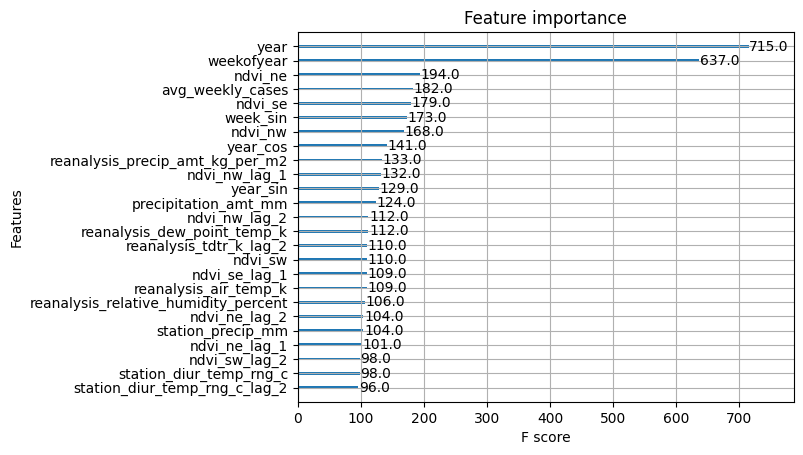

In [ ]:
plot_importance(sj_model, max_num_features=25)
plt.show()


In [ ]:
# Lets do feature selection:

col_selected = ['avg_weekly_cases', 'reanalysis_specific_humidity_g_per_kg_lag_2',
      'reanalysis_specific_humidity_g_per_kg','ndvi_se_lag_1',
      'reanalysis_dew_point_temp_k_lag_1','station_max_temp_c_lag_1',
      'reanalysis_specific_humidity_g_per_kg_lag_1' , 'station_min_temp_c_lag_2']

sj_X_new = sj_X2[col_selected]
iq_X_new = iq_X2[col_selected]


sj_test_new = sj_test3[col_selected]
iq_test_new = iq_test3[col_selected]

In [ ]:
# XGB takes long time

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

sj_train, sj_val, sj_train_label, sj_val_label = train_test_split(sj_X_new, sj_labels, test_size=0.2)
iq_train, iq_val, iq_train_label, iq_test_label = train_test_split(iq_X_new, iq_labels, test_size=0.2)


# XGradient Boost
"""sj_xgb = xgb.XGBRegressor(n_estimators = 1000, #  boosted trees
                                learning_rate = 0.005,
                                max_depth = 8,
                                subsample = 0.75,
                                colsample_bytree = 0.75,
                                gamma = .025,
                                nthread = 4)

sj_model = sj_xgb.fit(sj_train, sj_train_label.total_cases)
"""
grid_param = {
    'n_estimators': [500,1000],
    'learning_rate': [ 0.005, 0.01, 0.1],
    'max_depth': [4, 8, 12],
    'subsample': [0.75, 1.0],
    'colsample_bytree': [0.75, 1.0],
    'gamma' : [0.025, 0.01],
    'nthread' : [4,8]
    }

# cross validarion
sj_xgb_grid = GridSearchCV(estimator=xgb.XGBRegressor(),
                     param_grid=grid_param,
                     scoring='neg_mean_squared_error',
                     cv=3)
sj_xgb_grid.fit(sj_train, sj_train_label.total_cases)





'sj_xgb = xgb.XGBRegressor(n_estimators = 1000, #  boosted trees\n                                learning_rate = 0.005,\n                                max_depth = 8,\n                                subsample = 0.75,\n                                colsample_bytree = 0.75,\n                                gamma = .025,\n                                nthread = 4)\n\nsj_model = sj_xgb.fit(sj_train, sj_train_label.total_cases)\n'

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'colsample_bytree': [0.75, 1.0],
                         'gamma': [0.025, 0.01],
                         'learning_rate': [0.005, 0.01, 0.1],
                         'max_depth': [4, 8, 12], 'n_estimators': [500, 1000],
                         'nthread': [4, 8], 'subsample': [0.75, 1.0]},
             scoring='neg_mean_squared_error')

In [ ]:

sj_pred = sj_xgb_grid.predict(sj_val)
score = metrics.mean_absolute_error(sj_val_label.total_cases,sj_pred)
print(score) #MAE



20.385589295245232


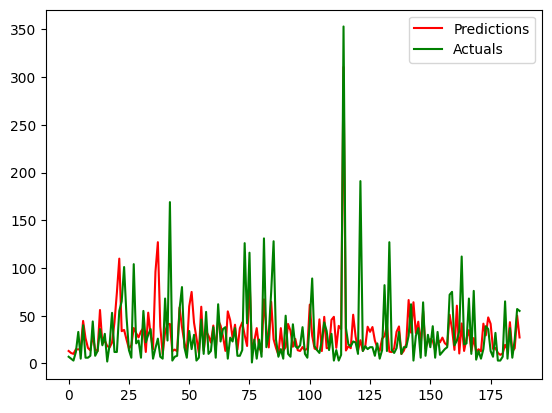

In [ ]:
sj_val_results = pd.DataFrame(data={'Val_Predictions':sj_pred, 'Actuals':sj_val_label.total_cases}).reset_index()
plt.plot(sj_val_results['Val_Predictions'], color='red',label="Predictions")
plt.plot(sj_val_results['Actuals'], color='green',label="Actuals")
plt.legend(loc='upper right')

<Axes: >

<Axes: >

Text(0.5, 0.98, 'Dengue Predicted Cases vs. Actual Cases in San Juan')

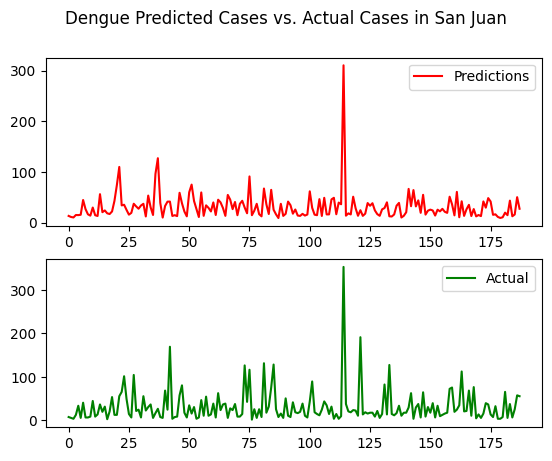

In [ ]:

# compare two predictions by figures
plt.subplot(211)
plt.plot(sj_val_results.Val_Predictions, color="red", label="Predictions")
plt.legend(loc='upper right')
plt.subplot(212)
plt.plot(sj_val_results.Actuals, color='green',label="Actual")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases in San Juan")
plt.legend()
plt.show()

In [ ]:
# Train on full data
sj_model_fulldata = sj_xgb_grid.fit(sj_X_new, sj_labels.total_cases)
sj_testset_prd = sj_model_fulldata.predict(sj_test_new)

In [ ]:
# IQ model

iq_train, iq_val, iq_train_label, iq_val_label = train_test_split(iq_X_new, iq_labels, test_size=0.2)


# XGradient Boost
"""iq_xgb = xgb.XGBRegressor(n_estimators = 1000, #  boosted trees
                                learning_rate = 0.005,
                                max_depth = 8,
                                subsample = 0.75,
                                colsample_bytree = 0.75,
                                gamma = .025,
                                nthread = 4)

iq_model = iq_xgb.fit(iq_train, iq_train_label.total_cases)
"""

grid_param = {
    'n_estimators': [500,1000],
    'learning_rate': [ 0.005, 0.01],
    'max_depth': [4, 8, 12],
    'subsample': [0.75, 1.0],
    'colsample_bytree': [0.75, 1.0],
    'gamma' : [0.025, 0.01],
    'nthread' : [4,8]
    }

# cross validarion
iq_xgb_grid = GridSearchCV(estimator=xgb.XGBRegressor(),
                     param_grid=grid_param,
                     scoring='neg_mean_squared_error',
                     cv=3)
iq_xgb_grid.fit(iq_train, iq_train_label.total_cases)





'iq_xgb = xgb.XGBRegressor(n_estimators = 1000, #  boosted trees\n                                learning_rate = 0.005,\n                                max_depth = 8,\n                                subsample = 0.75,\n                                colsample_bytree = 0.75,\n                                gamma = .025,\n                                nthread = 4)\n\niq_model = iq_xgb.fit(iq_train, iq_train_label.total_cases)\n'

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'colsample_bytree': [0.75, 1.0],
                         'gamma': [0.025, 0.01], 'learning_rate': [0.005, 0.01],
                         'max_depth': [4, 8, 12], 'n_estimators': [500, 1000],
                         'nthread': [4, 8], 'subsample': [0.75, 1.0]},
             scoring='neg_mean_squared_error')

In [ ]:

iq_pred = iq_xgb_grid.predict(iq_val)
score = metrics.mean_absolute_error(iq_val_label.total_cases,iq_pred)
print(score) #MAE


4.593257431800549


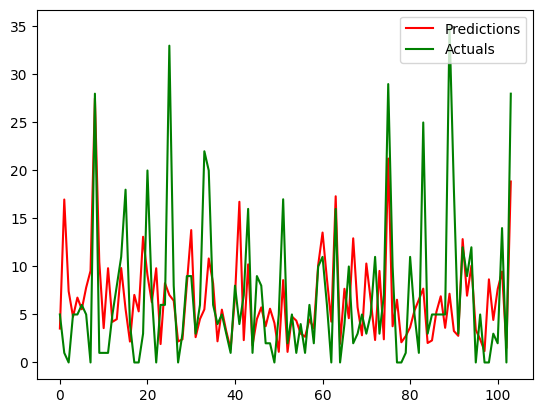

In [ ]:
iq_val_results = pd.DataFrame(data={'Val_Predictions':iq_pred, 'Actuals':iq_val_label.total_cases}).reset_index()
plt.plot(iq_val_results['Val_Predictions'], color='red',label="Predictions")
plt.plot(iq_val_results['Actuals'], color='green',label="Actuals")
plt.legend(loc='upper right')

<Axes: >

<Axes: >

Text(0.5, 0.98, 'Dengue Predicted Cases vs. Actual Cases in Iquitos')

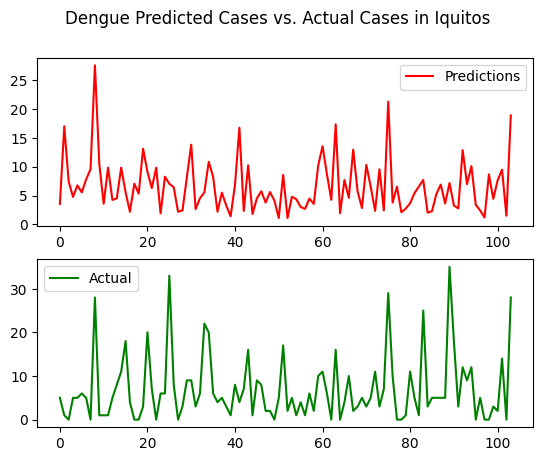

In [38]:
# compare two predictions by figures
plt.subplot(211)
plt.plot(iq_val_results.Val_Predictions, color="red", label="Predictions")
plt.legend(loc='upper right')
plt.subplot(212)
plt.plot(iq_val_results.Actuals, color='green',label="Actual")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases in Iquitos")
plt.legend()
plt.show()

In [ ]:
# Train on full data
iq_model_fulldata = iq_xgb_grid.fit(iq_X_new, iq_labels.total_cases)
iq_testset_prd = iq_model_fulldata.predict(iq_test_new)

In [ ]:
pred=pd.read_csv('submission_format.csv')#, index=[0,1,2])
pred = pred.set_index(['city','year','weekofyear']).drop('total_cases', axis=1)
pred.head(2)

Empty DataFrame
Columns: []
Index: [(sj, 2008, 18), (sj, 2008, 19)]

In [ ]:
pred['total_cases'] = pd.DataFrame(sj_testset_prd).append(pd.DataFrame(iq_testset_prd)).to_numpy()
pred= pred[['total_cases']].round(0).astype(int)
pred

<ipython-input-36-eed2a7b5cdf6>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred['total_cases'] = pd.DataFrame(sj_testset_prd).append(pd.DataFrame(iq_testset_prd)).to_numpy()


total_cases
city year weekofyear             
sj   2008 18                    5
          19                   13
          20                   15
          21                   14
          22                   12
...                           ...
iq   2013 22                    4
          23                    3
          24                    2
          25                    3
          26                    3

[416 rows x 1 columns]

In [ ]:
pred.to_csv('xgb_results_CV.csv')

In [ ]:
# Good results, MAE:  ----24.1418